In [286]:
## (1) try other BERT embeddings (/things the paper did)
## (2) run on all 3 datasets
## (3) 

In [287]:
#SETUP
## Create node data and central server data from the training data
## define teacher models for nodes and student model for central server

In [288]:
# !pip install datasets
# !pip install torchsummary

In [332]:
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import numpy as np
from torch.utils.data import Subset
import random
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [290]:
def BERT(text_Dataset):
    # Load pre-trained model tokenizer (vocabulary)
    #tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Load pre-trained model (weights)
    #model = BertModel.from_pretrained('bert-base-uncased').to(device) dmis-lab/biobert-v1.1


    # #biobert large cased
    #tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-large-cased-v1.1-squad")
    #model = AutoModel.from_pretrained("dmis-lab/biobert-large-cased-v1.1-squad").to(device)

    #biobert
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
    model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1").to(device)

    embeddings_list = []
    for text in text_Dataset:
        # Check if text is a string
        if not isinstance(text, str):
            raise ValueError(f"Expected string, but got {type(text)}. Please check your dataset.")

        # encoded_input = tokenizer(text, return_tensors='pt').to(device)
        encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        # Move tensors to the device
        encoded_input = {key: val.to(device) for key, val in encoded_input.items()}
        # Perform inference
        with torch.no_grad():
            model_output = model(**encoded_input)
            # Get the embeddings (CLS token)
            embeddings = model_output.last_hidden_state[:, 0, :]
            embeddings_list.append(embeddings.squeeze(0))
    return embeddings_list



# def split_dataset(dataset, num_clients):
#     shard_size = len(dataset) // num_clients
#     indices = list(range(len(dataset)))
#     np.random.shuffle(indices)
#     client_indices = [indices[i * shard_size:(i + 1) * shard_size] for i in range(num_clients)]
#     client_datasets = [Subset(dataset, indices) for indices in client_indices]
#     #client_datasets = [TensorDataset(data[0],data[1]) for data in client_datasets]
#     return client_datasets

def split_dataset(dataset, num_clients):
    x_data, y_data =dataset.tensors
    shard_size = len(dataset) // num_clients
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    client_indices = [indices[i * shard_size:(i + 1) * shard_size] for i in range(num_clients)]
     # Create subsets as TensorDatasets
    client_datasets = []
    for i in range(num_clients):
        start = i * shard_size
        end = (i + 1) * shard_size
        selected_indices = indices[start:end]

        # Slice the tensors and create TensorDataset
        client_x = x_data[selected_indices]
        client_y = y_data[selected_indices]
        client_datasets.append(TensorDataset(client_x, client_y))

    return client_datasets

def get_ensemble_outputs(models, inputs, temperature=1):
    outputs = []
    with torch.no_grad():
        for model in models:
            model.eval()
            logits = model(inputs)
            #logits = logits / temperature  # Apply temperature scaling
            outputs.append(torch.softmax(logits, dim=1))
    # Average the outputs
    ensemble_output = torch.mean(torch.stack(outputs), dim=0)
    return ensemble_output

In [291]:
## Load Data
#GAD, or Gene Association Database is a corpus of gene-disease associations curated from genetic association studies.
ds = load_dataset("bigbio/gad", "gad_blurb_bigbio_text")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure x_train, x_test, x_val are lists of strings
x_train = ds["train"]["text"]
y_train = ds["train"]["labels"]

# Make sure labels are integers
label_to_id = {'0': 0, '1': 1}
y_train = [label_to_id[label] if isinstance(label, str) else label for label in y_train]

# make sure training data are strings
x_train = [str(x) for x in x_train]


# define central server dataset D_v
size = round(0.05*len(x_train))
central_indices = list(range(0,size))

# define central data and train data
central_data = [data for i, data in enumerate(x_train) if i in central_indices]
central_outputs = [data for i, data in enumerate(y_train) if i in central_indices]
x_train = [data for i,data in enumerate(x_train) if i not in central_indices]
y_train = [data for i,data in enumerate(y_train) if i not in central_indices]

In [292]:
# ## Set up y_train and Central server data

# # Flatten y_train and central_outputs
y_train = [label for sublist in y_train for label in sublist]
central_outputs = [label for sublist in central_outputs for label in sublist]
# Convert string labels to integers
y_train = [int(label) for label in y_train]
central_outputs = [int(label) for label in central_outputs]


# Convert central_outputs and y_train to be tensors
central_outputs = torch.tensor(central_outputs, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)  # Convert labels to a tensor

In [293]:
## Use Pre-trained BERT to generate input empeddings for the training data
# Generate embeddings for train, test, and validation sets
x_train = BERT(x_train)
x_train = torch.stack(x_train)

## define the dimension of the BERT embedding
num_length = len(x_train[0])

In [294]:
## Similarly using BERT for central data embeddings
central_data = BERT(central_data)
central_data = torch.stack(central_data)

In [316]:
## define train and central TensorDatasets which we can use to create nodes
train_dataset = TensorDataset(x_train, y_train)
central_dataset = TensorDataset(central_data,central_outputs)

In [327]:
#Split the datasets into different nodes
num_clients = 10
client_datasets = split_dataset(train_dataset, num_clients)

In [317]:
## Define test dataset and val dataset
x_test = ds["test"]["text"]
y_test = ds["test"]["labels"]

x_val = ds["validation"]["text"]
y_val = ds["validation"]["labels"]

# x_test = [str(x) for x in x_test]
# x_val = [str(x) for x in x_val]
#batch_size =5

x_test = BERT(x_test)
x_test = torch.stack(x_test)
# Flatten y_test
y_test = [label for sublist in y_test for label in sublist]
# Convert string labels to integers
y_test = [int(label) for label in y_test]
y_test = torch.tensor(y_test, dtype=torch.long)  # Convert labels to a tensor
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=x_test.shape[0], shuffle=False)

x_val = BERT(x_val)
x_val = torch.stack(x_val)
# Flatten y_val
y_val = [label for sublist in y_val for label in sublist]
# Convert string labels to integers
y_val = [int(label) for label in y_val]
y_val = torch.tensor(y_val, dtype=torch.long)  # Convert labels to a tensor
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=x_val.shape[0], shuffle=False)

In [318]:
# Teacher model
class StudentModel(nn.Module):
    def __init__(self, dataset, num_length=num_length, num_class=2):
        self.dataset = dataset
        super(StudentModel, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(num_length, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.fc3 = nn.Linear(1200, num_class)
        self.dropout = nn.Dropout(p = 0.5)
    def forward(self,x_train):
        x = x_train.view(-1, num_length)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [298]:
#ALGORITHM
## Initialize the central server parameters
## Define a number of iterations to run the algorithm (for loop),
## 1st: select C-fraction of clients for the iteration (teacher models)
## 2nd: distribute current central server parameters to each client (student model)
## 3rd: run 'epochs' number of gradient descent steps on each of the selected clients for their local objectives
## 4th: predict on central server data with each of the selected clients
## 5th: split central server data into batches and perform gradient descent with each batch using CE + distillation loss

In [334]:
## Define parameters for the training algorithm below
communication_rounds = 20
local_epochs = 5
central_epochs = 5
C = 0.4 # fraction of num_clients selected in each communication round
batch_size = 32
alpha = 0.5 # between 0 and 1 to decide how much to use CE loss vs KLDivLoss on student_model (alpha weights KL, 1-alpha weights CE)
learning_rate = 0.00002
#num_clients = 100

In [345]:
## Save accuracies (FedAvg and Feded student_model) from each communication round
iteration = list(range(communication_rounds))
FedAvg_accuracies = []
Feded_accuracies = []
FedAvg_metrics = []
Feded_metrics = []

## Initialize central server parameters
student_model = StudentModel(dataset=central_dataset,num_length=num_length, num_class=2).to(device)
optimizer_student = optim.Adam(student_model.parameters(), lr=learning_rate)


## Initialize FedAvg model (here we won't use the dataset) and set them to zeros
FedAvg_model = StudentModel(dataset = central_dataset)

for h in range(communication_rounds):
    print("COMMUNICATION ROUND " + str(h) + "!!!")
    # get the current parameters of the student_model (central server model)
    x = student_model.state_dict()

    # get current FedAvg parameters
    x_avg = FedAvg_model.state_dict()

    # initialize each client model
    teacher_models = [StudentModel(dataset=client_datasets[i], num_length=num_length).to(device) for i in range(num_clients)]

    # initialize client models for FedAvg
    FedAvg_teacher_models = [StudentModel(dataset=client_datasets[i], num_length=num_length).to(device) for i in range(num_clients)]

    # select C-fraction of the nodes to use in the communication round
    J_t = random.sample(range(num_clients),int(round(C*num_clients)))

    # load student model parameters into each selected node
    for i in J_t:
        teacher_models[i].load_state_dict(x)
        FedAvg_teacher_models[i].load_state_dict(x_avg)
        # print(teacher_models[i].state_dict())
        # print(FedAvg_teacher_models[i].state_dict())

    ## zero out the FedAvg model parameters for use in next update
    for param in FedAvg_model.parameters():
        nn.init.zeros_(param)


    # local loss function
    criterion = nn.CrossEntropyLoss()
    criterion_kld = nn.KLDivLoss(reduction='batchmean')
    
    # Perform LocalUpdate for each selected node (first put TensorData into DataLoader with batch_size=B)
    for i in J_t:
        print(f"\nTraining Teacher Model {i+1}/{num_clients}")
        client_loader = DataLoader(client_datasets[i], batch_size=batch_size, shuffle=True)

        # define the optimizer
        optimizer = optim.Adam(teacher_models[i].parameters(), lr=learning_rate)
        optimizer_FedAvg = optim.Adam(FedAvg_teacher_models[i].parameters(),lr=learning_rate)

        # put into training mode
        teacher_models[i].train()

        # train
        for j in range(local_epochs):
            total_loss = 0
            num_correct = 0
            num_samples = 0

            for data, targets in client_loader:
                data = data.to(device)
                targets = targets.to(device)
    
                # Forward pass
                outputs = teacher_models[i](data)
                loss = criterion(outputs, targets)
    
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
    
                # Accumulate loss and accuracy
                total_loss += loss.item()
                predictions = outputs.argmax(dim=1)
                num_correct += (predictions == targets).sum().item()
                num_samples += targets.size(0)

            train_acc = num_correct / num_samples
            avg_loss = total_loss / len(client_loader)
            
            # # Evaluation on test set
            # teacher_models[i].eval()
            # # precision_metric.reset()
            # # recall_metric.reset()
            # test_correct = 0
            # test_samples = 0
    
            # with torch.no_grad():
            #     for x, y in test_loader:
            #         x = x.to(device)
            #         y = y.to(device)
    
            #         preds = teacher_models[i](x)
            #         predictions = preds.argmax(dim=1)
            #         test_correct += (predictions == y).sum().item()
            #         test_samples += y.size(0)

            # test_acc = test_correct / test_samples
            # print(f"Teacher Model {i+1}, Epoch {j+1}/{local_epochs}, "
            #   f"Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
            #   f"Test Accuracy: {test_acc:.4f}")

            #teacher_models[i].train()  # Switch back to training mode

        # train the FedAvg models
        for j in range(local_epochs):
            # define the optimizer
            optimizer_FedAvg = optim.Adam(FedAvg_teacher_models[i].parameters(),lr=learning_rate)
    
            # put into training mode
            FedAvg_teacher_models[i].train()
            
            for data, targets in client_loader:
                data = data.to(device)
                targets = targets.to(device)
    
                # FedAvg Forward pass
                outputs2 = FedAvg_teacher_models[i](data)
                loss2 = criterion(outputs2, targets)
    
                #FedAvg Backward pass and optimization
                optimizer_FedAvg.zero_grad()
                loss2.backward()
                optimizer_FedAvg.step()


    # get ensemble predictions from teacher_models and train student_model
    central_loader = DataLoader(central_dataset, batch_size = batch_size)

    for central_epoch in range(central_epochs):
        total_loss = 0
        num_correct = 0
        num_samples = 0
        for x, y in central_loader:
            x.to(device)
            y.to(device)
    
            # first get the student predictions (used for central_data CE loss and KLDivLoss with teacher_models)
            # for the teachers, we need probabilities, for the student, we need log-probabilities
            # ensemble_preds are really average softmax probabilities from the teacher_models
            student_logits = student_model(x)
            student_log_probs = F.log_softmax(student_logits,dim=1) # log probabilities for use in KLDivLoss for student_model
            student_probs = F.softmax(student_logits, dim=1) # for use in CELoss of the student_model
    
            with torch.no_grad():
                ensemble_probs = get_ensemble_outputs(teacher_models, x, temperature=1) #ensemble probabilties for use in KLDivLoss for student_model
                ensemble_preds = torch.log(ensemble_probs)
            
            # Compute Losses
            
            # Cross-Entropy Loss with unscaled logits (PyTorch CE Loss applies softmax internally)
            loss_ce = criterion(student_logits, y)
            
            # KL Divergence Loss between student and teacher ensemble
            loss_kld = criterion_kld(student_log_probs, ensemble_probs)
            
            # Total Loss
            loss = alpha * loss_kld + (1 - alpha) * loss_ce
            
            # # Get predicted labels from student_logits
            # _, predicted = torch.max(student_logits, 1)
    
            # # Move tensors to CPU and convert to NumPy arrays
            # predicted_np = predicted.cpu().numpy()
            # targets_np = targets.cpu().numpy()   
    
            # Backward pass and optimization
            optimizer_student.zero_grad()
            loss.backward()
            optimizer_student.step()

            # Accumulate loss and accuracy
            total_loss += loss.item()
            predictions = student_logits.argmax(dim=1)
            num_correct += (predictions == y).sum().item()
            num_samples += y.size(0)
            
        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / len(central_loader)
        train_acc = num_correct / num_samples
    
        # Evaluation on test set
        student_model.eval()
        test_correct = 0
        test_samples = 0
    
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
    
                preds = student_model(x)
                predictions = preds.argmax(dim=1)
                test_correct += (predictions == y).sum().item()
                test_samples += y.size(0)
                if h == (communication_rounds-1) and (central_epoch == (central_epochs-1)):
                    # Compute metrics
                    precision = precision_score(y, predictions, average='weighted', zero_division=0)
                    recall = recall_score(y, predictions, average='weighted', zero_division=0)
                    f1 = f1_score(y, predictions, average='weighted', zero_division=0)
                    Feded_metrics.append([precision,recall,f1])
    
        test_acc = test_correct / test_samples
        if central_epoch == (central_epochs-1):
            Feded_accuracies.append(test_acc)
                

        
        print(f"Student Model, Epoch {central_epoch+1}/{central_epochs}, Loss: {avg_loss:.4f}, "
              f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

    # For the FedAvg models, we don't train on the central server, we just average the parameters
    # FedAvg_model should be zero every time before doing this
    FedSD = FedAvg_model.state_dict()
    for i in J_t:
        #iterate through each model's keys and add them to the FedAvg_model
        for key in FedAvg_model.state_dict():
            # print(FedAvg_teacher_models[i].state_dict())
            FedSD[key] += FedAvg_teacher_models[i].state_dict()[key] / len(J_t)


    # Evaluation on test set
    FedAvg_model.eval()
    avg_test_correct = 0
    avg_test_samples = 0

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            avg_preds = FedAvg_model(x)
            avg_predictions = avg_preds.argmax(dim=1)
            avg_test_correct += (avg_predictions == y).sum().item()
            avg_test_samples += y.size(0)
            if h == (communication_rounds-1):
                # Compute metrics
                fed_precision = precision_score(y, avg_predictions, average='weighted', zero_division=0)
                fed_recall = recall_score(y, avg_predictions, average='weighted', zero_division=0)
                fed_f1 = f1_score(y, avg_predictions, average='weighted', zero_division=0)
                FedAvg_metrics.append([fed_precision,fed_recall,fed_f1])
            

    avg_test_acc = avg_test_correct / avg_test_samples
    FedAvg_accuracies.append(avg_test_acc)

    print(f"FedAvg Model Test Accuracy: {avg_test_acc:.4f}")




COMMUNICATION ROUND 0!!!

Training Teacher Model 5/10

Training Teacher Model 8/10

Training Teacher Model 9/10

Training Teacher Model 3/10
Student Model, Epoch 1/5, Loss: 0.3455, Train Accuracy: 0.5587, Test Accuracy: 0.5262
Student Model, Epoch 2/5, Loss: 0.3443, Train Accuracy: 0.5446, Test Accuracy: 0.5262
Student Model, Epoch 3/5, Loss: 0.3433, Train Accuracy: 0.5446, Test Accuracy: 0.5262
Student Model, Epoch 4/5, Loss: 0.3422, Train Accuracy: 0.5446, Test Accuracy: 0.5262
Student Model, Epoch 5/5, Loss: 0.3412, Train Accuracy: 0.5446, Test Accuracy: 0.5262
FedAvg Model Test Accuracy: 0.5262
COMMUNICATION ROUND 1!!!

Training Teacher Model 10/10

Training Teacher Model 9/10

Training Teacher Model 1/10

Training Teacher Model 2/10
Student Model, Epoch 1/5, Loss: 0.3401, Train Accuracy: 0.5540, Test Accuracy: 0.5281
Student Model, Epoch 2/5, Loss: 0.3389, Train Accuracy: 0.5587, Test Accuracy: 0.5412
Student Model, Epoch 3/5, Loss: 0.3377, Train Accuracy: 0.6009, Test Accuracy: 0

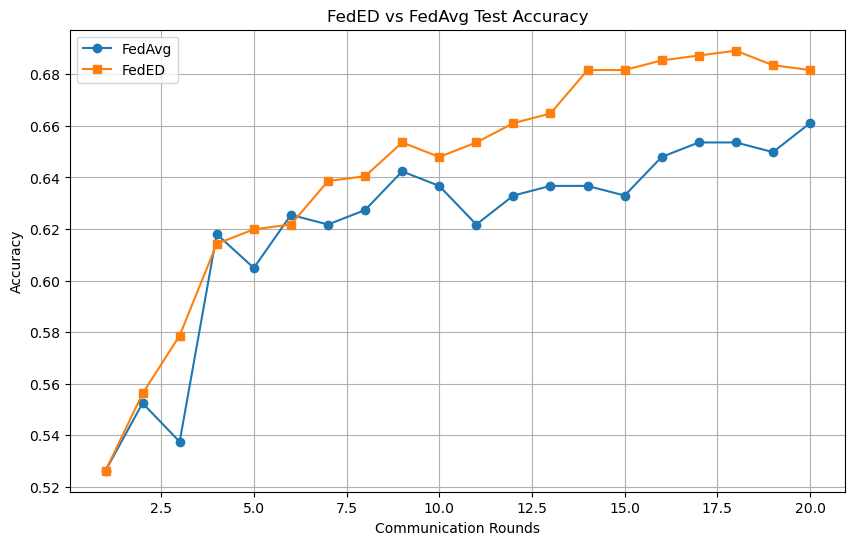

In [346]:
communication_rounds = communication_rounds
accuracies_list1 = [0.75, 0.78, 0.80, 0.82, 0.85, 0.87, 0.88, 0.89, 0.91, 0.92]  # Replace with your data
accuracies_list2 = [0.72, 0.74, 0.77, 0.79, 0.83, 0.85, 0.86, 0.88, 0.90, 0.91]  # Replace with your data

# Create the x-axis for communication rounds
rounds = list(range(1, communication_rounds + 1))

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(rounds, FedAvg_accuracies, label='FedAvg', marker='o')
plt.plot(rounds, Feded_accuracies, label='FedED', marker='s')

# Add labels, title, and legend
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy')
plt.title('FedED vs FedAvg Test Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [347]:
## Here let's print the confusion matrices, recall, precision, and F1 scores after training
print(FedAvg_metrics)
print(Feded_metrics)

[[0.6617023531905871, 0.6610486891385767, 0.6581469876438265]]
[[0.685523692399426, 0.6816479400749064, 0.6768970304288775]]
